In [1]:
# imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import classification_report
import tensorflow.keras as keras
import PIL.Image as Image
import lime

#import tensorflow_addons as tfa
#import tensorflow_datasets as tdfs

In [28]:
train_data_dir = 'data/short'

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=1500)

# Create the datasets
train_images, y_train = next(train_generator)


Found 1500 images belonging to 5 classes.


#### preview image labels

The labels are already in a format suited for modeling.

### reshape images

The images must be reshaped into a tensor before being input into a neural network model.

In [6]:
train_img_unrow = train_images.reshape(1500, -1)#.astype(uint8)

# Preview the shape of train_img_unrow
print(np.shape(train_img_unrow))

(1500, 49152)


#### normalize pixel values

In [7]:
train_img_unrow /= 255.

# Binary labeling

Label the data as belonging to one of 2 classes, healthy or diseased.

In [29]:
# make dataframe and preview
df = pd.DataFrame(y_train)
df

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0
1496,0.0,0.0,0.0,0.0,1.0
1497,0.0,0.0,1.0,0.0,0.0
1498,0.0,0.0,0.0,0.0,1.0


In [30]:
# copy the dataframe
new=df.copy()

new


,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0
1496,0.0,0.0,0.0,0.0,1.0
1497,0.0,0.0,1.0,0.0,0.0
1498,0.0,0.0,0.0,0.0,1.0


In [31]:
new.loc[new[4]==1,"Healthy"]=1
new.loc[new[4]==0,"Healthy"]=0
new.loc[new[4]==1,"Diseased"]=0
new.loc[new[4]==0,"Diseased"]=1
new

,0,1,2,3,4,Healthy,Diseased
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1496,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1497,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1498,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [32]:
new.drop([0, 1, 2, 3, 4], axis=1, inplace=True)

In [33]:
new.tail(5)

,Healthy,Diseased
1495,0.0,1.0
1496,1.0,0.0
1497,0.0,1.0
1498,1.0,0.0
1499,0.0,1.0


In [34]:
# check for any null entries
new.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [14]:
new['Healthy'].sum()


300.0

In [15]:
new['Diseased'].sum()


1200.0

In [40]:
cnn_train, cnn_test, cnn_train_labels, cnn_test_labels= train_test_split(train_images, y_train, test_size=0.2, random_state=42,shuffle=True)


In [41]:
np.random.seed(42)
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, 3))) 
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(5, activation='sigmoid'))

cnn_model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc', 'AUC'])
cnn_results = cnn_model.fit(cnn_train,
                            cnn_train_labels, 
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_test, cnn_test_labels))

Epoch 1/10
75/75 [==============================] - 4s 37ms/step - loss: nan - acc: 0.1958 - auc: 0.0025 - val_loss: nan - val_acc: 0.2200 - val_auc: 0.0000e+00
Epoch 2/10
75/75 [==============================] - 2s 31ms/step - loss: nan - acc: 0.1950 - auc: 0.0000e+00 - val_loss: nan - val_acc: 0.2200 - val_auc: 0.0000e+00
Epoch 3/10
75/75 [==============================] - 2s 31ms/step - loss: nan - acc: 0.1950 - auc: 0.0000e+00 - val_loss: nan - val_acc: 0.2200 - val_auc: 0.0000e+00
Epoch 4/10
75/75 [==============================] - 2s 30ms/step - loss: nan - acc: 0.1950 - auc: 0.0000e+00 - val_loss: nan - val_acc: 0.2200 - val_auc: 0.0000e+00
Epoch 5/10
75/75 [==============================] - 2s 31ms/step - loss: nan - acc: 0.1950 - auc: 0.0000e+00 - val_loss: nan - val_acc: 0.2200 - val_auc: 0.0000e+00
Epoch 6/10
75/75 [==============================] - 2s 32ms/step - loss: nan - acc: 0.1950 - auc: 0.0000e+00 - val_loss: nan - val_acc: 0.2200 - val_auc: 0.0000e+00
Epoch 7/10
75/

In [42]:
y_pred = cnn_model.predict(cnn_test)

10/10 [==============================] - 0s 13ms/step


In [43]:
print(classification_report(cnn_test_labels, np.round(y_pred)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [44]:
cnn_binary_train, cnn_binary_test, cnn_binary_train_labels, cnn_binary_test_labels= train_test_split(train_images, new, test_size=0.2, random_state=42,shuffle=True)


In [45]:
np.random.seed(42)
binary_cnn_model = models.Sequential()
binary_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, 3))) 
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Flatten())
binary_cnn_model.add(layers.Dense(64, activation='relu'))
binary_cnn_model.add(layers.Dense(2, activation='softmax'))

binary_cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['AUC', 'acc'])
binary_cnn_results = binary_cnn_model.fit(cnn_binary_train,
                            cnn_binary_train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_binary_test, cnn_binary_test_labels))

Epoch 1/10
75/75 [==============================] - 4s 35ms/step - loss: 1.7670 - auc: 0.7924 - acc: 0.7800 - val_loss: 0.4769 - val_auc: 0.8510 - val_acc: 0.8133
Epoch 2/10
75/75 [==============================] - 2s 31ms/step - loss: 0.4936 - auc: 0.8375 - acc: 0.7967 - val_loss: 0.4586 - val_auc: 0.8666 - val_acc: 0.8133
Epoch 3/10
75/75 [==============================] - 2s 31ms/step - loss: 0.4656 - auc: 0.8604 - acc: 0.7967 - val_loss: 0.4424 - val_auc: 0.8792 - val_acc: 0.8133
Epoch 4/10
75/75 [==============================] - 2s 32ms/step - loss: 0.4424 - auc: 0.8818 - acc: 0.7958 - val_loss: 0.4382 - val_auc: 0.8810 - val_acc: 0.8100
Epoch 5/10
75/75 [==============================] - 2s 31ms/step - loss: 0.4256 - auc: 0.8926 - acc: 0.8000 - val_loss: 0.4601 - val_auc: 0.8683 - val_acc: 0.8033
Epoch 6/10
75/75 [==============================] - 2s 32ms/step - loss: 0.4512 - auc: 0.8790 - acc: 0.8125 - val_loss: 0.4512 - val_auc: 0.8723 - val_acc: 0.8100
Epoch 7/10
75/75 [====

In [46]:

cnn_y_pred = binary_cnn_model.predict(cnn_binary_test)

10/10 [==============================] - 0s 16ms/step


In [47]:
print(classification_report(cnn_binary_test_labels, np.round(cnn_y_pred)))

              precision    recall  f1-score   support

           0       0.29      0.16      0.21        56
           1       0.83      0.91      0.87       244

   micro avg       0.77      0.77      0.77       300
   macro avg       0.56      0.54      0.54       300
weighted avg       0.73      0.77      0.74       300
 samples avg       0.77      0.77      0.77       300



## visualize layers

In [48]:
layer_outputs = [layer.output for layer in binary_cnn_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=binary_cnn_model.input, outputs=layer_outputs)

binary_cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        16416     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 6, 6, 64)         

### View third channel of first activation layer

In [49]:
# Returns an array for each activation layer
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

47/47 [==============================] - 1s 24ms/step


ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_47_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[1500,62,62,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:ConcatV2] name: concat

## channel 30 of first activation layer

In [50]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

22/47 [=============>................] - ETA: 0s

ResourceExhaustedError: Graph execution error:

Detected at node model_1/max_pooling2d_15/MaxPool defined at (most recent call last):
  File "C:\Users\lalyn\anaconda3\lib\runpy.py", line 197, in _run_module_as_main

  File "C:\Users\lalyn\anaconda3\lib\runpy.py", line 87, in _run_code

  File "C:\Users\lalyn\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\lalyn\anaconda3\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\lalyn\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 725, in start

  File "C:\Users\lalyn\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\lalyn\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever

  File "C:\Users\lalyn\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once

  File "C:\Users\lalyn\anaconda3\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\lalyn\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue

  File "C:\Users\lalyn\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one

  File "C:\Users\lalyn\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell

  File "C:\Users\lalyn\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\lalyn\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "C:\Users\lalyn\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell

  File "C:\Users\lalyn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell

  File "C:\Users\lalyn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell

  File "C:\Users\lalyn\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner

  File "C:\Users\lalyn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async

  File "C:\Users\lalyn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes

  File "C:\Users\lalyn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code

  File "C:\Users\lalyn\AppData\Local\Temp\ipykernel_23276\400607622.py", line 2, in <module>

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\layers\pooling\base_pooling2d.py", line 84, in call

OOM when allocating tensor with shape[32,31,31,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node model_1/max_pooling2d_15/MaxPool}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_38972]

## view channel i of first activation layer

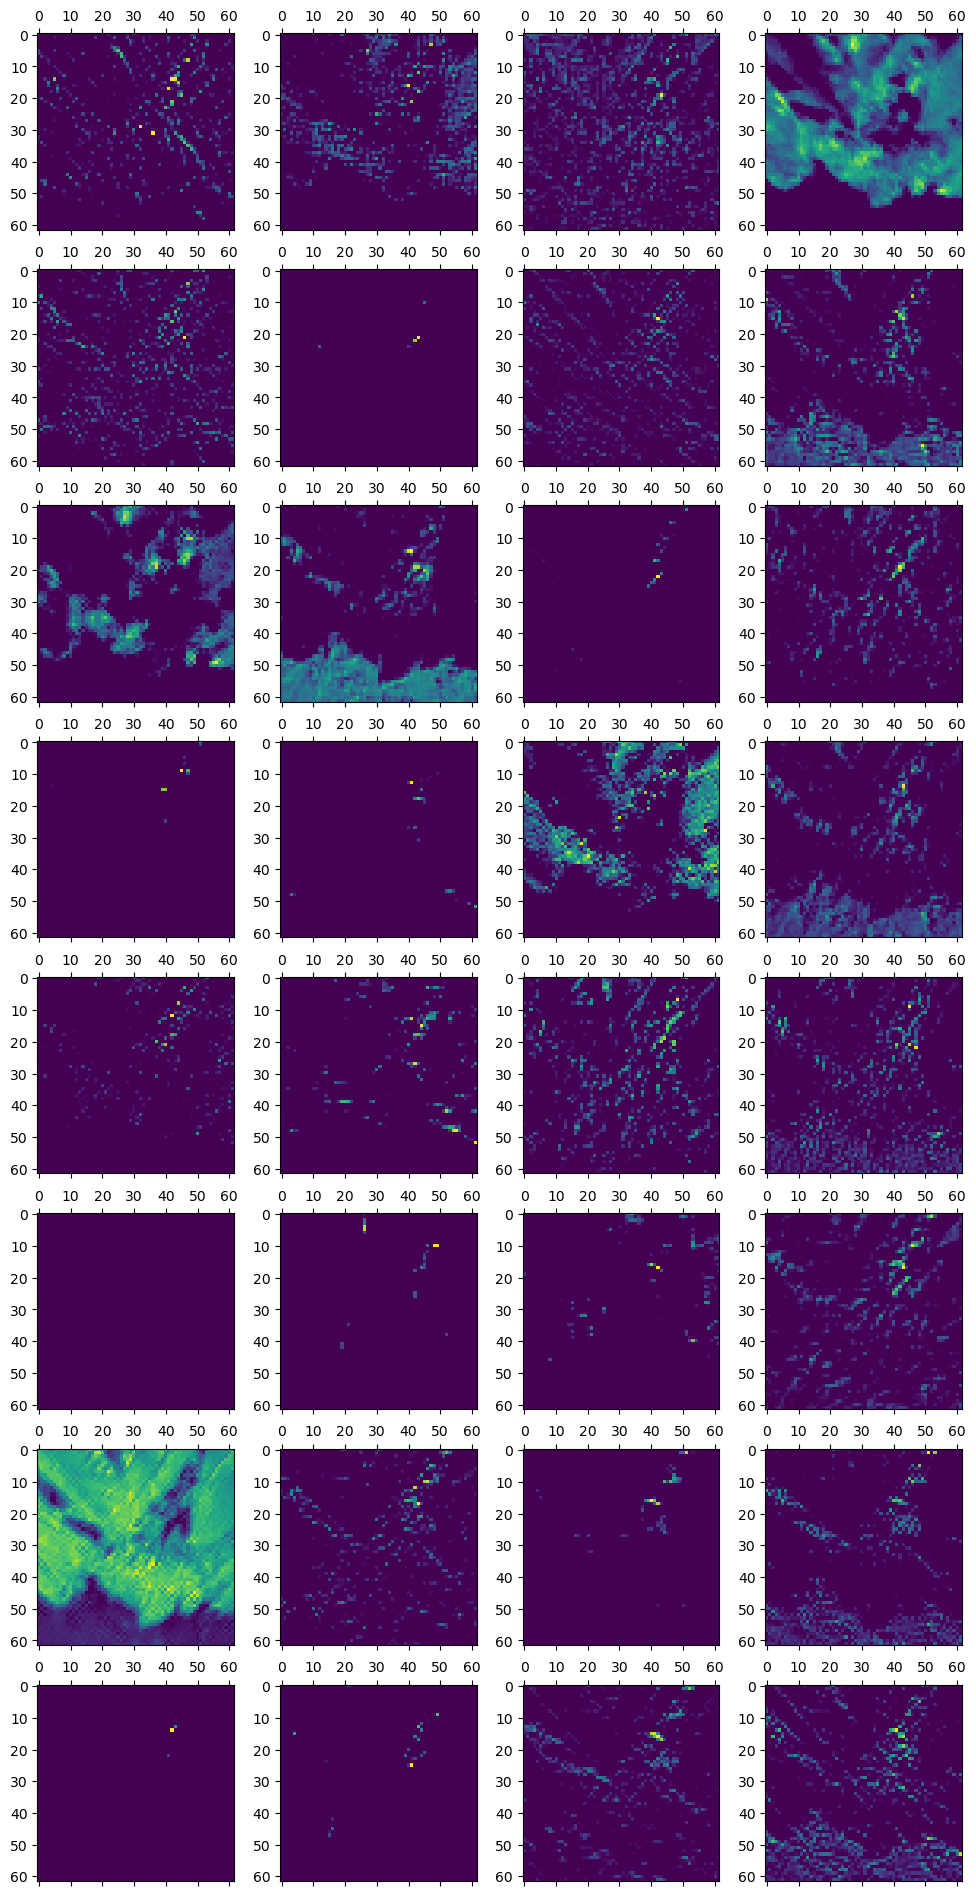

In [61]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### View channel 29 for all activation layers

NameError: name 'activations' is not defined

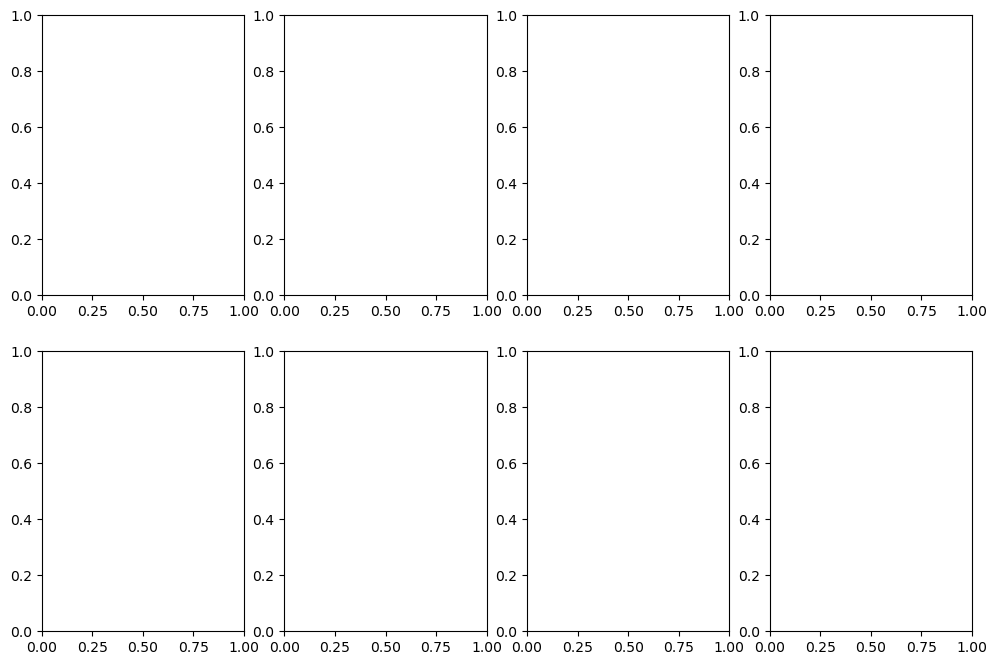

In [51]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in cnn_model.layers[:6]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

### visualize activation layers  lab - plot feature maps for each channel of all the layers

In [52]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in cnn_model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=cnn_model.input, outputs=layer_outputs)

activations = activation_model.predict(train_images)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std() 
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

47/47 [==============================] - 1s 23ms/step


ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_47_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[1500,62,62,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:ConcatV2] name: concat